This is Will's edit of a notebook originally written by Javier.

# Correlations between H II region parameters

We look at correlations between 6 principal measurements that fall into two groups: 

* Basic parameters: 
    * Size: $S$
    * Ionizing luminosity: $L(\mathrm{H\alpha})$
    * Distance: $d$
    * Velocity dispersion on line of sigth: $\sigma_{\text{los}}$
* Velocity structure function parameters:
    * Velocity dispersion on plane of sky: $\sigma_{\text{pos}}$
    * Velocity autocorrelation length scale: $r_0$
    * Structure function slope in inertial range: $m$

In [1]:
from pathlib import Path


import time
start_time=time.time()
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
import lmfit
import statsmodels.api as sm
import linmix
from scipy.stats import pearsonr
import pickle
import math
import itertools
import json
from logerr import logify



Load Table with physical properties

In [2]:
physical_data = pd.read_table('property-regions-data.csv', delimiter=',')
#physical_data = physical_data.drop(physical_data .index[[5]])

In [3]:
physical_data 

,Region,LHa,LHaer,SFR,n,L [pc],Ler [pc],Dist [kpc],Dister [kpc],siglos [km/s],sigloser [km/s],Diam [pc],Diamer [pc]
0,NGC 604,2.630000e+39,2.630000e+38,0.005300,0.35,400,40.0,840.00,30.00,17.51,0.30,400,40.0
1,NGC 595,8.910000e+38,8.910000e+37,0.002600,1.66,400,40.0,840.00,30.00,16.52,0.09,400,40.0
2,Hubble X,1.620000e+38,1.620000e+37,0.000310,0.35,160,16.0,500.00,40.00,10.00,0.02,160,16.0
3,Hubble V,1.990000e+38,1.990000e+37,0.000150,0.11,130,13.0,500.00,40.00,9.79,0.03,130,13.0
4,30Dor,2.930000e+39,2.930000e+38,0.013000,6.16,370,37.0,50.00,0.19,21.77,2.20,370,37.0
5,Carina,1.020000e+39,1.020000e+38,0.010000,2.26,200,20.0,2.35,0.05,18.60,3.30,200,20.0
6,NGC 346,6.000000e+38,6.000000e+37,0.002100,1.20,220,22.0,61.70,1.10,9.58,1.00,220,22.0
7,M8,3.000000e+37,3.000000e+36,0.000100,0.44,25,2.5,1.25,0.10,11.25,1.60,25,2.5
8,OrionS,1.510000e+37,1.510000e+36,0.000053,0.03,5,0.5,0.40,0.02,9.90,1.20,5,0.5


Path names

In [4]:
datapath_names = Path(open("path-name-list.txt", "r").read()).expanduser()

In [5]:
samples=pd.read_csv(str(datapath_names) +'//sample-names-corr.csv',header=None)
Names=pd.read_csv(str(datapath_names) +'//formal-names-corr.csv',header=None)

Load Results

In [6]:
datapath_res = Path(open("path-results2.txt", "r").read()).expanduser()

In [7]:
datapath_res 

WindowsPath('C:/Users/ZAINTEL2/Documents/Aeon/GitHub/PhD.Paper/result-files_new_s0')

In [8]:
data = {}
Results = {}

for i in range(len(samples)):
    data[samples[0][i]] = json.load(open(str(datapath_res) + '/' + samples[0][i] + ".json"))

In [9]:
#sigma
sig = [[0]*(1) for i in range(len(samples))]
siger = [[0]*(1) for i in range(len(samples))]

#velocity dispersion with 2-sig intervals
sig2 = [[0]*(1) for i in range(len(samples))]
#sig2er = [[0]*(1) for i in range(len(samples))]
sig2s2 = [[0]*(1) for i in range(len(samples))]
sig2s2p = [[0]*(1) for i in range(len(samples))]
sig2s2m = [[0]*(1) for i in range(len(samples))]

#correlation length with 2-sig intervals
r0 = [[0]*(1) for i in range(len(samples))]
#r0er = [[0]*(1) for i in range(len(samples))]
r0s2 = [[0]*(1) for i in range(len(samples))]
r0s2p = [[0]*(1) for i in range(len(samples))]
r0s2m = [[0]*(1) for i in range(len(samples))]

#power-law
m = [[0]*(1) for i in range(len(samples))]
#mer = [[0]*(1) for i in range(len(samples))]
ms2 = [[0]*(1) for i in range(len(samples))]
ms2p = [[0]*(1) for i in range(len(samples))]
ms2m = [[0]*(1) for i in range(len(samples))]

#noise with 2-sig intervals
bn = [[0]*(1) for i in range(len(samples))]
#ner = [[0]*(1) for i in range(len(samples))]
bns2 = [[0]*(1) for i in range(len(samples))]
bns2p = [[0]*(1) for i in range(len(samples))]
bns2m = [[0]*(1) for i in range(len(samples))]

#seeing with 2-sig intervals
s0 = [[0]*(1) for i in range(len(samples))]
#s0er = [[0]*(1) for i in range(len(samples))]
s0s2 = [[0]*(1) for i in range(len(samples))]
s0s2p = [[0]*(1) for i in range(len(samples))]
s0s2m = [[0]*(1) for i in range(len(samples))]

pc = [[0]*(1) for i in range(len(samples))]
box_size = [[0]*(1) for i in range(len(samples))]

In [10]:
results_='results_2sig'

for i in range(len(samples)):    
    
    sig2[i] = data[samples[0][i]][results_]['sig2'][0]
    sig2s2p[i] = data[samples[0][i]][results_]['sig2'][1]
    sig2s2m[i] = data[samples[0][i]][results_]['sig2'][2]
    
    r0[i]    = data[samples[0][i]][results_]['r0'][0]
    r0s2p[i] = data[samples[0][i]][results_]['r0'][1]
    r0s2m[i] = data[samples[0][i]][results_]['r0'][2]
    
    m[i]    = data[samples[0][i]][results_]['m'][0]
    ms2p[i] = data[samples[0][i]][results_]['m'][1]
    ms2m[i] = data[samples[0][i]][results_]['m'][2]
    
    bn[i]    = data[samples[0][i]][results_]['noise'][0]
    bns2p[i] = data[samples[0][i]][results_]['noise'][1]
    bns2m[i] = data[samples[0][i]][results_]['noise'][2]
    
    s0[i]    = data[samples[0][i]][results_]['s0'][0]
    s0s2p[i] = data[samples[0][i]][results_]['s0'][1]
    s0s2m[i] = data[samples[0][i]][results_]['s0'][2]
    
    box_size[i] = data[samples[0][i]]['properties']['box_size']
    pc[i] = data[samples[0][i]]['properties']['pc']

In [11]:
s0f = pd.DataFrame(
    {
        "s0 [RMS]":s0,
        "s0+[RMS]": s0s2p,
        "s0-[RMS]": s0s2m,  
       "s0 [FWHM]": np.array(s0)*2.35/np.array(pc),
       "s0- [FWHM]": np.array(s0s2m)*2.35/np.array(pc),
       "s0+ [FWHM]": np.array(s0s2p)*2.35/np.array(pc),
        "bn ":bn,
        "bn+": bns2p,
        "bn- ": bns2m,     
    }
)

s0f.insert(loc=0, column='Region', value=Names)


s0f.round(4)

,Region,s0 [RMS],s0+[RMS],s0-[RMS],s0 [FWHM],s0- [FWHM],s0+ [FWHM],bn,bn+,bn-
0,NGC 604,1.6214,0.9761,0.5962,0.9356,0.3440,0.5633,0.3275,0.6929,0.3072
1,NGC 595,0.4072,0.4546,-0.0036,0.2350,-0.0021,0.2623,1.7945,1.5873,1.1112
2,Hubble X,0.2788,0.2683,0.0314,0.2703,0.0304,0.2601,0.3212,0.4275,0.2373
3,Hubble V,0.2624,0.4120,0.0087,0.2544,0.0084,0.3994,0.0000,0.6545,-0.0105
4,30 Dor,0.1213,0.0665,0.0345,1.1760,0.3340,0.6450,6.1555,1.5745,1.5605
5,Carina,0.0058,0.0093,0.0044,1.3145,0.9954,2.1250,2.2580,2.4804,1.9536
6,NGC 346,0.0858,0.0203,0.0141,0.6706,0.1102,0.1587,0.8402,0.0699,0.0694
7,M8,0.0054,0.0035,0.0045,2.0801,1.7639,1.3616,0.4367,0.2144,0.2943
8,Orion,0.0016,0.0002,0.0002,1.8458,0.1903,0.2359,0.0252,0.0049,0.0050


In [12]:
s1f = pd.DataFrame(
    {
        "sig2":sig2,
        "sig2+": sig2s2p,
        "sig2-": sig2s2m,
        "r0":r0,
        "r0+": r0s2p,
        "r0-": r0s2m,
        "m":m,
        "m+": ms2p,
        "m-": ms2m,
        "fov": box_size,
       
    }
)

s1f.insert(loc=0, column='Region', value=Names)


s1f.round(4)

,Region,sig2,sig2+,sig2-,r0,r0+,r0-,m,m+,m-,fov
0,NGC 604,84.2214,21.8752,10.3894,12.0876,6.6913,4.6437,0.7751,0.2026,0.2493,173.4419
1,NGC 595,53.6367,4.4367,1.9465,11.1531,0.7407,0.8763,1.3606,0.0873,0.1528,196.2758
2,Hubble X,14.7118,2.6265,0.4209,4.0994,0.3145,0.1890,1.0161,0.0554,0.2363,78.0350
3,Hubble V,9.7489,2.8360,0.3667,3.5620,0.4321,1.2762,0.8104,0.0703,0.2848,61.2194
4,30 Dor,296.8446,39.1649,18.5287,3.8578,1.0652,0.4657,0.8520,0.0773,0.1380,31.5129
5,Carina,18.1267,1.4602,1.4921,0.5505,0.0817,0.0682,1.1584,0.2776,0.1795,19.6636
6,NGC 346,32.9306,2.5519,1.4875,2.3737,0.2946,0.1600,0.9564,0.0484,0.0704,20.1903
7,M8,7.3827,1.2391,0.7283,1.0346,0.2369,0.1219,1.2640,0.1744,0.1928,16.0964
8,Orion,12.6284,0.7340,0.5229,0.0680,0.0061,0.0041,1.0734,0.0311,0.0385,0.4541


In [13]:
physical_data

,Region,LHa,LHaer,SFR,n,L [pc],Ler [pc],Dist [kpc],Dister [kpc],siglos [km/s],sigloser [km/s],Diam [pc],Diamer [pc]
0,NGC 604,2.630000e+39,2.630000e+38,0.005300,0.35,400,40.0,840.00,30.00,17.51,0.30,400,40.0
1,NGC 595,8.910000e+38,8.910000e+37,0.002600,1.66,400,40.0,840.00,30.00,16.52,0.09,400,40.0
2,Hubble X,1.620000e+38,1.620000e+37,0.000310,0.35,160,16.0,500.00,40.00,10.00,0.02,160,16.0
3,Hubble V,1.990000e+38,1.990000e+37,0.000150,0.11,130,13.0,500.00,40.00,9.79,0.03,130,13.0
4,30Dor,2.930000e+39,2.930000e+38,0.013000,6.16,370,37.0,50.00,0.19,21.77,2.20,370,37.0
5,Carina,1.020000e+39,1.020000e+38,0.010000,2.26,200,20.0,2.35,0.05,18.60,3.30,200,20.0
6,NGC 346,6.000000e+38,6.000000e+37,0.002100,1.20,220,22.0,61.70,1.10,9.58,1.00,220,22.0
7,M8,3.000000e+37,3.000000e+36,0.000100,0.44,25,2.5,1.25,0.10,11.25,1.60,25,2.5
8,OrionS,1.510000e+37,1.510000e+36,0.000053,0.03,5,0.5,0.40,0.02,9.90,1.20,5,0.5


In [14]:
data = pd.DataFrame(
    {
       "Region": physical_data.Region,
       "LHa": physical_data.LHa,
       "LHaer": physical_data.LHaer,
       "SFR": physical_data.SFR,
       "n": physical_data.n,
       "L [pc]": physical_data['Diam [pc]'],
       "Ler [pc]": physical_data['Diamer [pc]'],
       "Dist [kpc]": physical_data['Dist [kpc]'],
       "Dister [kpc]": physical_data['Dister [kpc]'],
        
       "sig2 [km/s]": sig2,
       "sig2er": sig2s2p,
        "sig [km/s]": np.array(sig2)**0.5,
       "siger": (np.array(sig2s2p)/np.array(sig2))*np.array(sig2)**0.5,
        "m": m,
       "mer": ms2p,
       "r0 [pc]": r0,
       "r0er": r0s2p,
       "fov [pc]": box_size,
        "fover [pc]": np.array(box_size)*0.1,
        
       "siglos [km/s]": physical_data['siglos [km/s]'],
       "sigloser [km/s]": physical_data['sigloser [km/s]'],
      
    },
)

In [15]:
data.dtypes

Region              object
LHa                float64
LHaer              float64
SFR                float64
n                  float64
L [pc]               int64
Ler [pc]           float64
Dist [kpc]         float64
Dister [kpc]       float64
sig2 [km/s]        float64
sig2er             float64
sig [km/s]         float64
siger              float64
m                  float64
mer                float64
r0 [pc]            float64
r0er               float64
fov [pc]           float64
fover [pc]         float64
siglos [km/s]      float64
sigloser [km/s]    float64
dtype: object

In [16]:
data.round(4)

,Region,LHa,LHaer,SFR,n,L [pc],Ler [pc],Dist [kpc],Dister [kpc],sig2 [km/s],...,sig [km/s],siger,m,mer,r0 [pc],r0er,fov [pc],fover [pc],siglos [km/s],sigloser [km/s]
0,NGC 604,2.630000e+39,2.630000e+38,0.0053,0.35,400,40.0,840.00,30.00,84.2214,...,9.1772,2.3836,0.7751,0.2026,12.0876,6.6913,173.4419,17.3442,17.51,0.30
1,NGC 595,8.910000e+38,8.910000e+37,0.0026,1.66,400,40.0,840.00,30.00,53.6367,...,7.3237,0.6058,1.3606,0.0873,11.1531,0.7407,196.2758,19.6276,16.52,0.09
2,Hubble X,1.620000e+38,1.620000e+37,0.0003,0.35,160,16.0,500.00,40.00,14.7118,...,3.8356,0.6848,1.0161,0.0554,4.0994,0.3145,78.0350,7.8035,10.00,0.02
3,Hubble V,1.990000e+38,1.990000e+37,0.0001,0.11,130,13.0,500.00,40.00,9.7489,...,3.1223,0.9083,0.8104,0.0703,3.5620,0.4321,61.2194,6.1219,9.79,0.03
4,30Dor,2.930000e+39,2.930000e+38,0.0130,6.16,370,37.0,50.00,0.19,296.8446,...,17.2292,2.2732,0.8520,0.0773,3.8578,1.0652,31.5129,3.1513,21.77,2.20
5,Carina,1.020000e+39,1.020000e+38,0.0100,2.26,200,20.0,2.35,0.05,18.1267,...,4.2575,0.3430,1.1584,0.2776,0.5505,0.0817,19.6636,1.9664,18.60,3.30
6,NGC 346,6.000000e+38,6.000000e+37,0.0021,1.20,220,22.0,61.70,1.10,32.9306,...,5.7385,0.4447,0.9564,0.0484,2.3737,0.2946,20.1903,2.0190,9.58,1.00
7,M8,3.000000e+37,3.000000e+36,0.0001,0.44,25,2.5,1.25,0.10,7.3827,...,2.7171,0.4560,1.2640,0.1744,1.0346,0.2369,16.0964,1.6096,11.25,1.60
8,OrionS,1.510000e+37,1.510000e+36,0.0001,0.03,5,0.5,0.40,0.02,12.6284,...,3.5536,0.2065,1.0734,0.0311,0.0680,0.0061,0.4541,0.0454,9.90,1.20


In [17]:
cols = data.columns
logdata = data.copy()
for col in cols:
    if col not in ["Region", "m", "mer", "r0er", "siger",  "sig2er", "Ler [pc]", "Dister [kpc]","LHaer","sigloser [km/s]","fover [pc]"]:
        logdata[col] = np.round(np.log10(logdata[col]), 2)
        logdata.rename(columns={col: f"log {col}"}, inplace=True)
# Some minor changes to column names
logdata.rename(
    columns={
        "log LHa": "log L(H) [erg s^-1]",
        }, 
    inplace=True)
logdata

,Region,log L(H) [erg s^-1],LHaer,log SFR,log n,log L [pc],Ler [pc],log Dist [kpc],Dister [kpc],log sig2 [km/s],...,log sig [km/s],siger,m,mer,log r0 [pc],r0er,log fov [pc],fover [pc],log siglos [km/s],sigloser [km/s]
0,NGC 604,39.42,2.630000e+38,-2.28,-0.46,2.60,40.0,2.92,30.00,1.93,...,0.96,2.383642,0.775080,0.202591,1.08,6.691312,2.24,17.344190,1.24,0.30
1,NGC 595,38.95,8.910000e+37,-2.59,0.22,2.60,40.0,2.92,30.00,1.73,...,0.86,0.605805,1.360615,0.087265,1.05,0.740691,2.29,19.627578,1.22,0.09
2,Hubble X,38.21,1.620000e+37,-3.51,-0.46,2.20,16.0,2.70,40.00,1.17,...,0.58,0.684778,1.016079,0.055376,0.61,0.314483,1.89,7.803498,1.00,0.02
3,Hubble V,38.30,1.990000e+37,-3.82,-0.96,2.11,13.0,2.70,40.00,0.99,...,0.49,0.908308,0.810436,0.070281,0.55,0.432116,1.79,6.121941,0.99,0.03
4,30Dor,39.47,2.930000e+38,-1.89,0.79,2.57,37.0,1.70,0.19,2.47,...,1.24,2.273175,0.851966,0.077269,0.59,1.065182,1.50,3.151289,1.34,2.20
5,Carina,39.01,1.020000e+38,-2.00,0.35,2.30,20.0,0.37,0.05,1.26,...,0.63,0.342961,1.158387,0.277592,-0.26,0.081746,1.29,1.966360,1.27,3.30
6,NGC 346,38.78,6.000000e+37,-2.68,0.08,2.34,22.0,1.79,1.10,1.52,...,0.76,0.444701,0.956386,0.048356,0.38,0.294612,1.31,2.019033,0.98,1.00
7,M8,37.48,3.000000e+36,-4.00,-0.36,1.40,2.5,0.10,0.10,0.87,...,0.43,0.456023,1.263970,0.174350,0.01,0.236922,1.21,1.609644,1.05,1.60
8,OrionS,37.18,1.510000e+36,-4.28,-1.52,0.70,0.5,-0.40,0.02,1.10,...,0.55,0.206548,1.073374,0.031140,-1.17,0.006079,-0.34,0.045405,1.00,1.20


Uncertainties Log Space

In [18]:
logdata['Ler [pc]']=(data['Ler [pc]']/data['L [pc]'])*0.434
logdata['sigloser [km/s]']=(data['sigloser [km/s]']/data['siglos [km/s]'])*0.434
logdata['LHaer']=(data['LHaer']/data['LHa'])*0.434
logdata['Dister [kpc]']=(data['Dister [kpc]']/data['Dist [kpc]'])*0.434
logdata['mer']=(data['mer']/data['m'])*0.434
logdata['r0er']=(data['r0er']/data['r0 [pc]'])*0.434
logdata['siger']=(data['siger']/data['sig [km/s]'])*0.434
logdata['sig2er']=(data['sig2er']/data['sig2 [km/s]'])*0.434
logdata['fover [pc]']=(data['fover [pc]']/data['fov [pc]'])*0.434

In [19]:
logdata

,Region,log L(H) [erg s^-1],LHaer,log SFR,log n,log L [pc],Ler [pc],log Dist [kpc],Dister [kpc],log sig2 [km/s],...,log sig [km/s],siger,m,mer,log r0 [pc],r0er,log fov [pc],fover [pc],log siglos [km/s],sigloser [km/s]
0,NGC 604,39.42,0.0434,-2.28,-0.46,2.60,0.0434,2.92,0.015500,1.93,...,0.96,0.112725,0.775080,0.113439,1.08,0.240248,2.24,0.0434,1.24,0.007436
1,NGC 595,38.95,0.0434,-2.59,0.22,2.60,0.0434,2.92,0.015500,1.73,...,0.86,0.035900,1.360615,0.027835,1.05,0.028823,2.29,0.0434,1.22,0.002364
2,Hubble X,38.21,0.0434,-3.51,-0.46,2.20,0.0434,2.70,0.034720,1.17,...,0.58,0.077483,1.016079,0.023653,0.61,0.033294,1.89,0.0434,1.00,0.000868
3,Hubble V,38.30,0.0434,-3.82,-0.96,2.11,0.0434,2.70,0.034720,0.99,...,0.49,0.126254,0.810436,0.037637,0.55,0.052650,1.79,0.0434,0.99,0.001330
4,30Dor,39.47,0.0434,-1.89,0.79,2.57,0.0434,1.70,0.001649,2.47,...,1.24,0.057261,0.851966,0.039362,0.59,0.119832,1.50,0.0434,1.34,0.043859
5,Carina,39.01,0.0434,-2.00,0.35,2.30,0.0434,0.37,0.009234,1.26,...,0.63,0.034960,1.158387,0.104002,-0.26,0.064451,1.29,0.0434,1.27,0.077000
6,NGC 346,38.78,0.0434,-2.68,0.08,2.34,0.0434,1.79,0.007737,1.52,...,0.76,0.033632,0.956386,0.021943,0.38,0.053866,1.31,0.0434,0.98,0.045303
7,M8,37.48,0.0434,-4.00,-0.36,1.40,0.0434,0.10,0.034720,0.87,...,0.43,0.072840,1.263970,0.059865,0.01,0.099381,1.21,0.0434,1.05,0.061724
8,OrionS,37.18,0.0434,-4.28,-1.52,0.70,0.0434,-0.40,0.021700,1.10,...,0.55,0.025225,1.073374,0.012591,-1.17,0.038823,-0.34,0.0434,1.00,0.052606


In [20]:
#logify(data['L [pc]'],data['Ler [pc]'])

Make the label text bigger on the figures

In [21]:
sns.set_context("talk", font_scale=1.2)

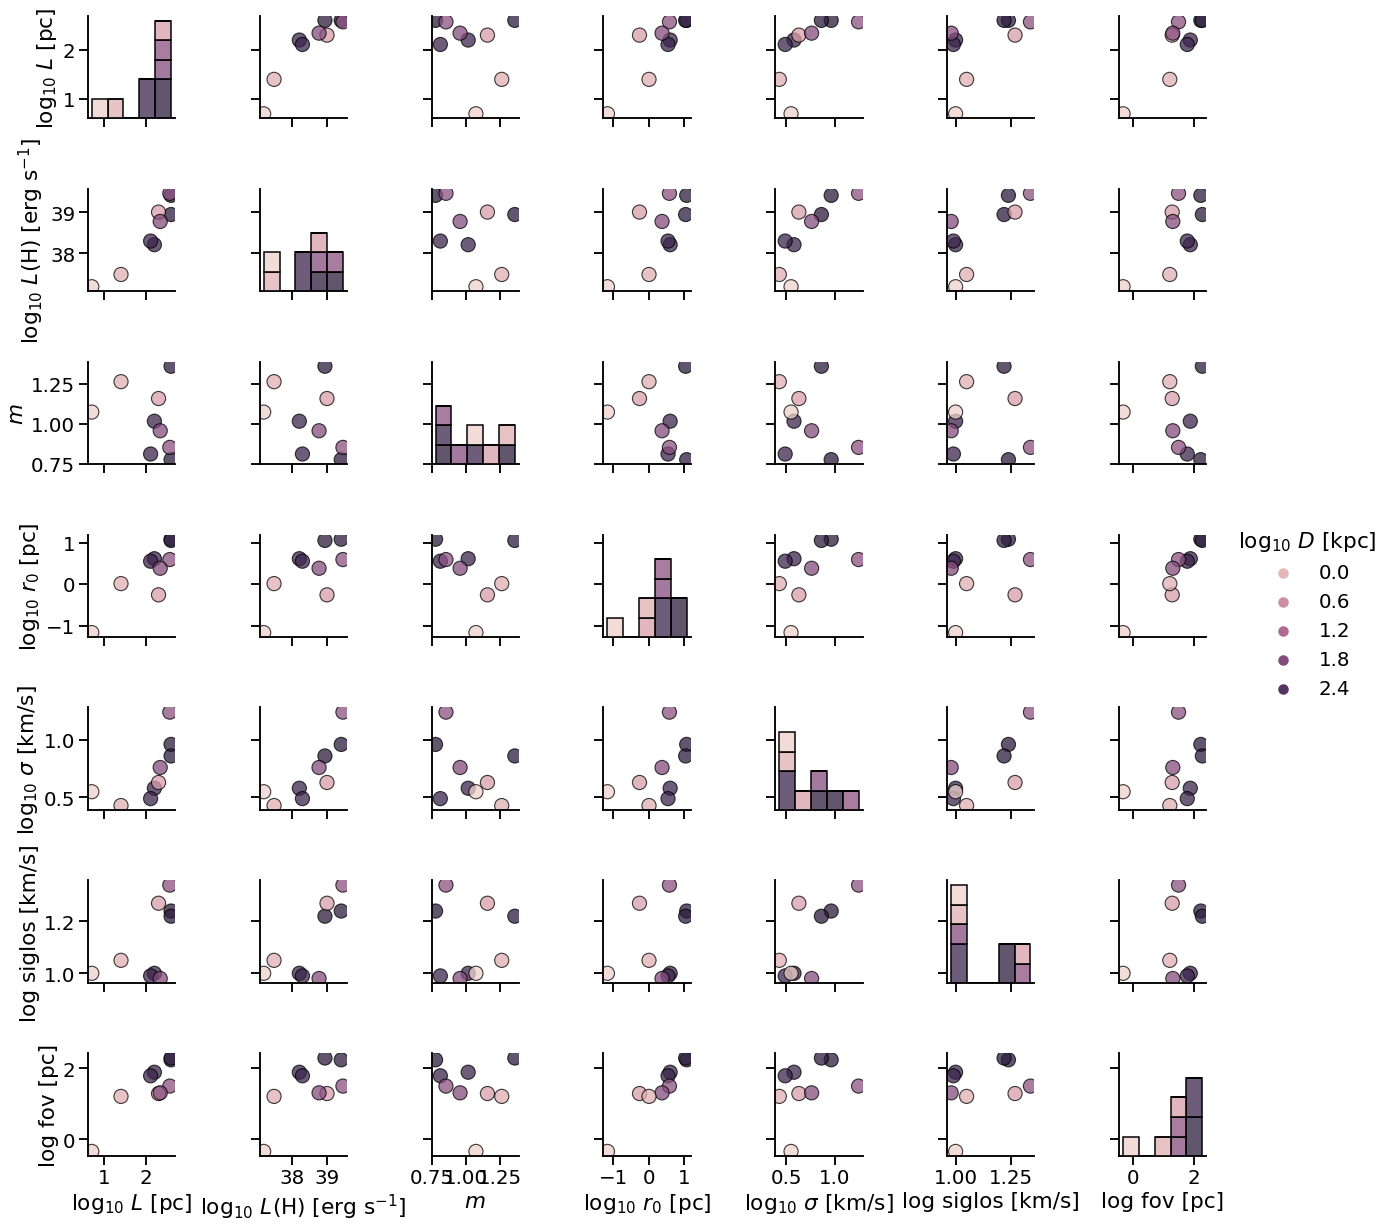

In [22]:
selected_vars = [ "log L [pc]","log L(H) [erg s^-1]", "log Dist [kpc]", "m", "log r0 [pc]", "log sig [km/s]", "log siglos [km/s]", "log fov [pc]"]
plotdata = logdata[selected_vars].rename(
    columns={
        # Switch column names to use latex formatting to improve axis labels
        "log L [pc]": r"$\log_{10}\ L$ [pc]", 
        "log L(H) [erg s^-1]": r"$\log_{10}\ L(\mathrm{H})$ [erg s$^{-1}$]", 
        "m": "$m$", 
        "log r0 [pc]": r"$\log_{10}\ r_0$ [pc]", 
        "log sig [km/s]": r"$\log_{10}\ \sigma$ [km/s]", 
        "log Dist [kpc]": r"$\log_{10}\ D$ [kpc]",
    },
)

sns.pairplot(plotdata, 
             hue=r"$\log_{10}\ D$ [kpc]",
             plot_kws=dict(alpha=0.75, s=200, edgecolor="k"), 
             diag_kind='hist',
             diag_kws= dict(multiple='stack'),
             );

figname = "strucfunc-correlations"
# Save PDF and JPG versions of the figure
#plt.gcf().savefig(f"{figname}.pdf")
plt.gcf().savefig(f"{figname}.jpg")

## Correlation coefficients

Calculate [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient), $r$, between each pair of variables:

In [23]:
logdata[selected_vars].corr()

,log L [pc],log L(H) [erg s^-1],log Dist [kpc],m,log r0 [pc],log sig [km/s],log siglos [km/s],log fov [pc]
log L [pc],1.000000,0.928771,0.767302,-0.254579,0.859830,0.637923,0.561549,0.868083
log L(H) [erg s^-1],0.928771,1.000000,0.585013,-0.349838,0.694310,0.807362,0.748863,0.676679
log Dist [kpc],0.767302,0.585013,1.000000,-0.367233,0.912951,0.381084,0.113487,0.864923
m,-0.254579,-0.349838,-0.367233,1.000000,-0.235581,-0.340502,0.006403,-0.122597
log r0 [pc],0.859830,0.694310,0.912951,-0.235581,1.000000,0.496490,0.325497,0.960405
log sig [km/s],0.637923,0.807362,0.381084,-0.340502,0.496490,1.000000,0.752345,0.351425
log siglos [km/s],0.561549,0.748863,0.113487,0.006403,0.325497,0.752345,1.000000,0.353528
log fov [pc],0.868083,0.676679,0.864923,-0.122597,0.960405,0.351425,0.353528,1.000000


So the results for correlations between the basic parameters are what we would expect:

- Size is moderately correlated with luminosity ($r = 0.67$).  The correlation is only weak because size will also depend on ambient density and the age of the region. 
- Size is highly correlated with distance ($r = 0.92$).  This is just a selection effect due to the fact that we tend to choose regions that have an angular size that matches our instruments. 
- Luminosity–distance correlation is the weakest ($r = 0.71$), and can be explained as being due to the previous two.



The correlations of the structure function parameters with the basic parameters are very interesting:
- Autocorrelation length scale, $r_0$, is *highly* correlated ($r = 0.96$) with region size, $L$.  Looking at the graph, the relation seems to be approximately linear with $\ell_0 \approx 0.1 L$.  How much of this correlation is real and how much is down to selection effects is something we need to consider carefully.
- Velocity dispersion, $\sigma$, is well correlated ($r = 0.71$) with luminosity, $L(\mathrm{Ha})$.  
- The structure function slope $m$ is well correlated ($r = 0.73$) with distance.  This is mainly because $m \approx 1.6$ for all the distant regions observed with TAURUS and ISIS, but is around $m = 1$ for all the nearby regions.  I suspect that this is mainly a data quality issue: we observe very little of the inertial range in the distant regions, so the determination of $m$ is probably not so reliable.  But I am not sure why this would tend to bias $m$ towards high values. 

## Significance tests

We can calculate the statistical significance of the correlations by using the Student t-statistic.  We test the null hypothesis that a given pair of variables is truly uncorrelated ($r = 0$) for the underlying population and that the observed $r$ for our sample of $N = 9$ sources arises solely by chance.  We want to calculate the $p$-value, which is the probability of obtaining $r$ greater than or equal to the observed value, given that there is no true correlation.  A small value of $p$ means that the null hypothesis can be rejected at a certain confidence level.  

First we calculate the t-statistic from the Pearson correlation coefficient:
$$
t = r \, \left(\frac{N - 2}{1 - r^2}\right)^{1/2}
$$
Then, we use the cumulative distribution function (CDF) of the t-distribution with $N - 1$ degrees of freedom to find the p-value. 

In [24]:
def tstatistic(r, n):
    """Compute Student t statistic for null hypothesis of no correlation
    for an observed Pearson correlation of `r` from `n` samples
    """
    return r*np.sqrt((n - 2) / (1 - r**2))

In [25]:
import scipy.stats

In [26]:
def p_from_t(t, n):
    """Compute 1-sided p-value from Student statistic `t` with `n` observations"""
    # sf is survival function: 1 - CDF
    return scipy.stats.t.sf(t, n-1)

In [27]:
N = 9
rvals = np.array([0.0, 0.2, 0.4, 0.5, 0.6, 0.7, 0.779, 0.8, 0.9, 0.908, 0.95, 0.981])
tvals = tstatistic(rvals, N)
pvals = p_from_t(tvals, N)
pd.DataFrame(
    {"r": rvals, "t": tvals, "p": pvals}
)

,r,t,p
0,0.000,0.000000,5.000000e-01
1,0.200,0.540062,3.019294e-01
2,0.400,1.154701,1.407685e-01
3,0.500,1.527525,8.257494e-02
4,0.600,1.984313,4.124805e-02
5,0.700,2.593355,1.597303e-02
6,0.779,3.287020,5.535582e-03
7,0.800,3.527668,3.879201e-03
8,0.900,5.462793,2.997718e-04
9,0.908,5.733922,2.184923e-04


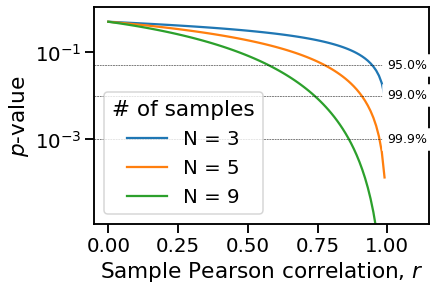

In [28]:
fig, ax = plt.subplots()
for N in 3, 5, 9:
    rvals = np.linspace(0.0, 1.0, 100, endpoint=False)
    tvals = tstatistic(rvals, N)
    pvals = p_from_t(tvals, N)
    ax.plot(rvals, pvals, label=f"N = {N}")
for p0 in 0.05, 0.01, 0.001:
    ax.axhline(p0, color="k", ls="--", lw=0.5)
    ax.text(1.07, p0, f"{100*(1-p0):.1f}%", 
            va="center", ha="center", fontsize="xx-small", 
            bbox={"color": "w"})
ax.legend(title="# of samples")
ax.set(
    xlabel="Sample Pearson correlation, $r$",
    ylabel="$p$-value",
    yscale="log",
    xlim=[-0.05, 1.15],
    ylim=[1.1e-5, 1.1],
);

I have marked confidence levels for nominal $p$-values of 0.05, 0.01, and 0.001, which are often used to judge significance.   This implies that all the correlations that we listed above are highly significant.  For instance, the correlation of $\sigma$ with luminosity, with $r=0.77$, has $p = 0.011$, so close to the 99% confidence level. 

Despite the good correlation, there is a factor of 4 difference in $\sigma$ between Carina and 30~Dor, despite similar luminosities.  **Need to check these luminostiy values**. 

In [29]:
logdata

,Region,log L(H) [erg s^-1],LHaer,log SFR,log n,log L [pc],Ler [pc],log Dist [kpc],Dister [kpc],log sig2 [km/s],...,log sig [km/s],siger,m,mer,log r0 [pc],r0er,log fov [pc],fover [pc],log siglos [km/s],sigloser [km/s]
0,NGC 604,39.42,0.0434,-2.28,-0.46,2.60,0.0434,2.92,0.015500,1.93,...,0.96,0.112725,0.775080,0.113439,1.08,0.240248,2.24,0.0434,1.24,0.007436
1,NGC 595,38.95,0.0434,-2.59,0.22,2.60,0.0434,2.92,0.015500,1.73,...,0.86,0.035900,1.360615,0.027835,1.05,0.028823,2.29,0.0434,1.22,0.002364
2,Hubble X,38.21,0.0434,-3.51,-0.46,2.20,0.0434,2.70,0.034720,1.17,...,0.58,0.077483,1.016079,0.023653,0.61,0.033294,1.89,0.0434,1.00,0.000868
3,Hubble V,38.30,0.0434,-3.82,-0.96,2.11,0.0434,2.70,0.034720,0.99,...,0.49,0.126254,0.810436,0.037637,0.55,0.052650,1.79,0.0434,0.99,0.001330
4,30Dor,39.47,0.0434,-1.89,0.79,2.57,0.0434,1.70,0.001649,2.47,...,1.24,0.057261,0.851966,0.039362,0.59,0.119832,1.50,0.0434,1.34,0.043859
5,Carina,39.01,0.0434,-2.00,0.35,2.30,0.0434,0.37,0.009234,1.26,...,0.63,0.034960,1.158387,0.104002,-0.26,0.064451,1.29,0.0434,1.27,0.077000
6,NGC 346,38.78,0.0434,-2.68,0.08,2.34,0.0434,1.79,0.007737,1.52,...,0.76,0.033632,0.956386,0.021943,0.38,0.053866,1.31,0.0434,0.98,0.045303
7,M8,37.48,0.0434,-4.00,-0.36,1.40,0.0434,0.10,0.034720,0.87,...,0.43,0.072840,1.263970,0.059865,0.01,0.099381,1.21,0.0434,1.05,0.061724
8,OrionS,37.18,0.0434,-4.28,-1.52,0.70,0.0434,-0.40,0.021700,1.10,...,0.55,0.025225,1.073374,0.012591,-1.17,0.038823,-0.34,0.0434,1.00,0.052606


# Correlation between results 

In [30]:
X, Xe, Y, Ye = [logdata[_] for _ in ['log fov [pc]', 'fover [pc]','log r0 [pc]', 'r0er']]

In [31]:
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

In [32]:
lm.run_mcmc(silent=True)

In [33]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)

In [34]:
pearsonr(X, Y)

(0.9604048008893623, 3.912441838634828e-05)

In [35]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

,X,Xe,Y,Ye
count,9.000000,9.000000e+00,9.000000,9.000000
mean,1.464444,4.340000e-02,0.315556,0.081263
std,0.786322,2.453269e-18,0.705020,0.066892
min,-0.340000,4.340000e-02,-1.170000,0.028823
25%,1.290000,4.340000e-02,0.010000,0.038823
50%,1.500000,4.340000e-02,0.550000,0.053866
75%,1.890000,4.340000e-02,0.610000,0.099381
max,2.290000,4.340000e-02,1.080000,0.240248


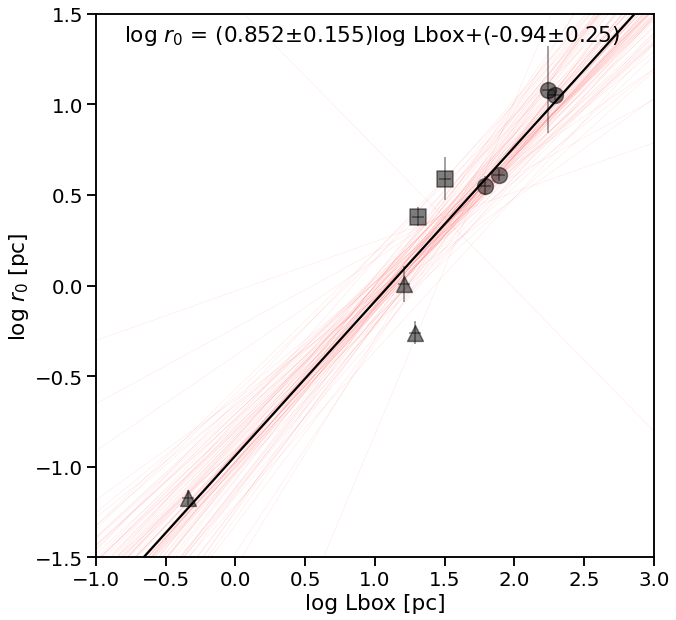

In [36]:
vmin, vmax = -1.0, 3.0
xgrid = np.linspace(vmin, vmax, 200)

fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k")

for samp in lm.chain[::100]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.15, lw=0.35,zorder=0)
    
ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k",zorder=6)

marker=itertools.cycle(('o','o','o','o','s','^','s','^','^'))

marker=itertools.cycle(('o','o','o','o','s','^','s','^','^'))
#for i in [0,1,2,3,4,6,8]:
for i in range(len(samples)):
    ax.scatter(X[i], Y[i], marker=next(marker), s=250,zorder=5, c ='k', alpha=0.5)

# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")

ax.text(.05, .95,'log $r_{0}$ = (' 
        + str(np.round(dfchain["beta"].mean(),3)) + '$\pm$' + str(np.round(dfchain["beta"].std(),3))
        + ')log Lbox+('
        + str(np.round(dfchain["alpha"].mean(),3)) + '$\pm$' + str(np.round(dfchain["alpha"].std(),3))
        + ')',  color='k', transform=ax.transAxes)
    
ax.set(
    xlim=[-1, 3], ylim=[-1.5, 1.5],
    xlabel=r"log Lbox [pc]", ylabel=r"log $r_{0}$ [pc]",
)

plt.savefig('Imgs//corr-rvsfov_new_s0.pdf', bbox_inches='tight')


- r0 vs m

In [37]:
X, Xe, Y, Ye = [logdata[_] for _ in ['log r0 [pc]', 'r0er','m', 'mer']]

In [38]:
Y=np.log10(Y)

In [39]:
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

In [40]:
lm.run_mcmc(silent=True)

In [41]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)

In [42]:
pearsonr(X, Y)

(-0.288530266383725, 0.45147632700263773)

In [43]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

,X,Xe,Y,Ye
count,9.000000,9.000000,9.000000,9.000000
mean,0.315556,0.081263,0.005125,0.048925
std,0.705020,0.066892,0.085778,0.036513
min,-1.170000,0.028823,-0.110653,0.012591
25%,0.010000,0.038823,-0.069578,0.023653
50%,0.550000,0.053866,0.006927,0.037637
75%,0.610000,0.099381,0.063854,0.059865
max,1.080000,0.240248,0.133735,0.113439


[(-0.2, 0.2),
 Text(0, 0.5, 'log $m$'),
 (-1.5, 1.5),
 Text(0.5, 0, 'log $r_{0}$ [pc]')]

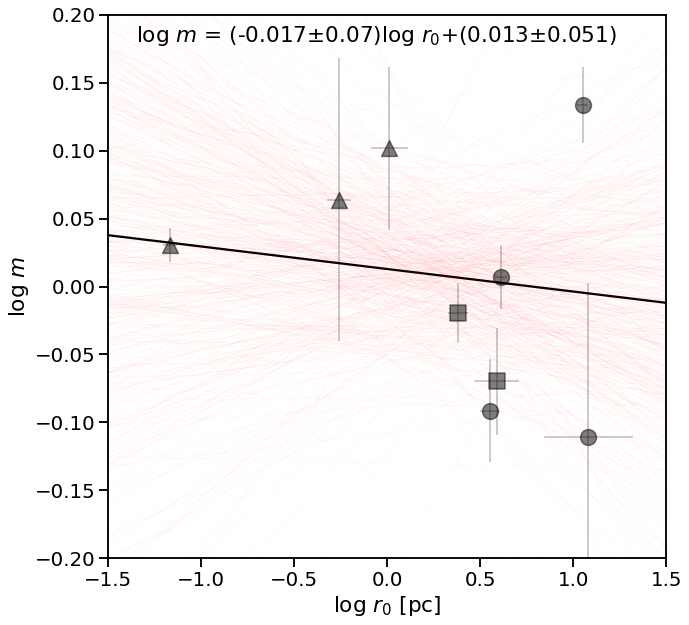

In [44]:
vmin, vmax = -1.5, 1.5
xgrid = np.linspace(vmin, vmax, 200)

fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k")

marker=itertools.cycle(('o','o','o','o','s','^','s','^','^'))
#for i in [0,1,2,3,4,6,8]:
for i in range(len(samples)):
    ax.scatter(X[i], Y[i], marker=next(marker), s=250,zorder=5, c ='k', alpha=0.5)

# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")
for samp in lm.chain[::20]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.2, lw=0.1)

ax.text(.05, .95,'log $m$ = (' 
        + str(np.round(dfchain["beta"].mean(),3)) + '$\pm$' + str(np.round(dfchain["beta"].std(),3))
        + ')log $r_{0}$+('
        + str(np.round(dfchain["alpha"].mean(),3)) + '$\pm$' + str(np.round(dfchain["alpha"].std(),3))
        + ')',  color='k', transform=ax.transAxes)
    
ax.set(
    xlim=[-1.5, 1.5], ylim=[-0.2, 0.2],
    xlabel=r"log $r_{0}$ [pc]", ylabel=r"log $m$",
)

In [45]:
tab=['Y','X','a','b','r','p']

In [46]:
tab0 = ['log $m$','log $r_{0}$',np.round(dfchain["beta"].mean(),2),np.round(dfchain["beta"].std(),2),
       np.round(dfchain["alpha"].mean(),2),np.round(dfchain["alpha"].std(),2),
      np.round(pearsonr(X, Y)[0],2),np.round(pearsonr(X, Y)[1],3)]

- r0 vs sig

In [47]:
X, Xe, Y, Ye = [logdata[_] for _ in ['log r0 [pc]', 'r0er','log sig [km/s]', 'siger']]

lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

lm.run_mcmc(silent=True)

In [48]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)

In [49]:
pearsonr(X, Y)

(0.49649028894598224, 0.17397404370423075)

In [50]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

,X,Xe,Y,Ye
count,9.000000,9.000000,9.000000,9.000000
mean,0.315556,0.081263,0.722222,0.064031
std,0.705020,0.066892,0.260470,0.036424
min,-1.170000,0.028823,0.430000,0.025225
25%,0.010000,0.038823,0.550000,0.034960
50%,0.550000,0.053866,0.630000,0.057261
75%,0.610000,0.099381,0.860000,0.077483
max,1.080000,0.240248,1.240000,0.126254


[(0.0, 1.5),
 Text(0, 0.5, 'log $\\sigma$ [km/s]'),
 (-1.5, 1.5),
 Text(0.5, 0, 'log $r_{0}$ [pc]')]

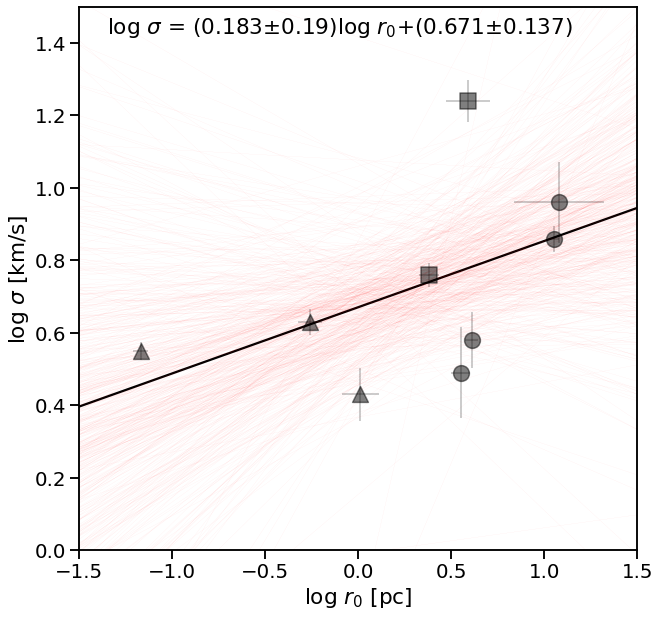

In [51]:
vmin, vmax = -1.5, 1.5
xgrid = np.linspace(vmin, vmax, 200)


fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k")

marker=itertools.cycle(('o','o','o','o','s','^','s','^','^'))
#for i in [0,1,2,3,4,6,8]:
for i in range(len(samples)):
    ax.scatter(X[i], Y[i], marker=next(marker), s=250,zorder=5, c ='k', alpha=0.5)

# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")
for samp in lm.chain[::20]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.2, lw=0.1)
    
ax.text(.05, .95,'log $\sigma$ = (' 
        + str(np.round(dfchain["beta"].mean(),3)) + '$\pm$' + str(np.round(dfchain["beta"].std(),3))
        + ')log $r_{0}$+('
        + str(np.round(dfchain["alpha"].mean(),3)) + '$\pm$' + str(np.round(dfchain["alpha"].std(),3))
        + ')',  color='k', transform=ax.transAxes)

    
ax.set(
    xlim=[-1.5, 1.5], ylim=[0, 1.5],
    xlabel=r"log $r_{0}$ [pc]", ylabel=r"log $\sigma$ [km/s]",
)

In [52]:
tab1 = ['log $\sigma$','log $r_{0}$',np.round(dfchain["beta"].mean(),2),np.round(dfchain["beta"].std(),2),
       np.round(dfchain["alpha"].mean(),2),np.round(dfchain["alpha"].std(),2),
      np.round(pearsonr(X, Y)[0],2),np.round(pearsonr(X, Y)[1],3)]
tab1

['log $\\sigma$', 'log $r_{0}$', 0.18, 0.19, 0.67, 0.14, 0.5, 0.174]

- log sig vs log m

In [53]:
X, Xe, Y, Ye = [logdata[_] for _ in ['log sig [km/s]', 'siger','m', 'mer']]

In [54]:
Y=np.log10(Y)

In [55]:
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

In [56]:
lm.run_mcmc(silent=True)

In [57]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)

In [58]:
pearsonr(X, Y)

(-0.365585353205085, 0.3332769501065119)

In [59]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

,X,Xe,Y,Ye
count,9.000000,9.000000,9.000000,9.000000
mean,0.722222,0.064031,0.005125,0.048925
std,0.260470,0.036424,0.085778,0.036513
min,0.430000,0.025225,-0.110653,0.012591
25%,0.550000,0.034960,-0.069578,0.023653
50%,0.630000,0.057261,0.006927,0.037637
75%,0.860000,0.077483,0.063854,0.059865
max,1.240000,0.126254,0.133735,0.113439


[(-0.2, 0.2),
 Text(0, 0.5, 'log $m$'),
 (0.0, 1.5),
 Text(0.5, 0, 'log $\\sigma$ [km/s]')]

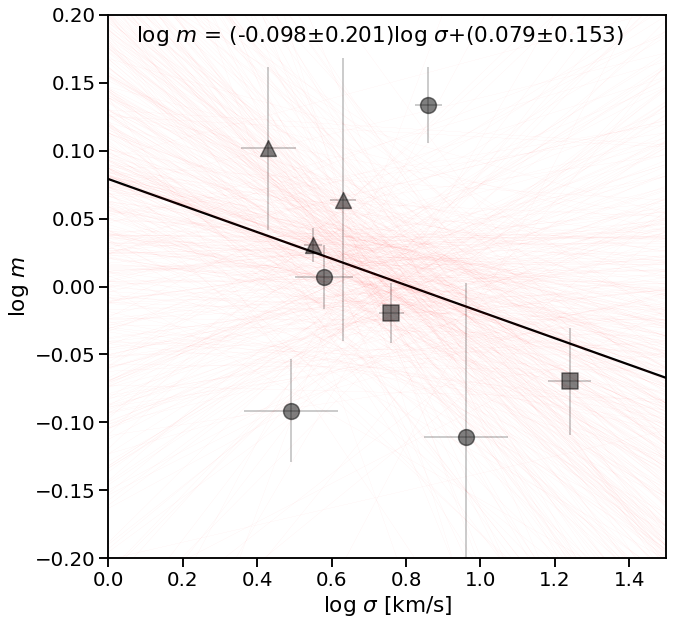

In [60]:
vmin, vmax = 0, 1.5
xgrid = np.linspace(vmin, vmax, 200)


fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k")

marker=itertools.cycle(('o','o','o','o','s','^','s','^','^'))
#for i in [0,1,2,3,4,6,8]:
for i in range(len(samples)):
    ax.scatter(X[i], Y[i], marker=next(marker), s=250,zorder=5, c ='k', alpha=0.5)

# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")
for samp in lm.chain[::20]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.2, lw=0.1)
    
ax.text(.05, .95,'log $m$ = (' 
        + str(np.round(dfchain["beta"].mean(),3)) + '$\pm$' + str(np.round(dfchain["beta"].std(),3))
        + ')log $\sigma$+('
        + str(np.round(dfchain["alpha"].mean(),3)) + '$\pm$' + str(np.round(dfchain["alpha"].std(),3))
        + ')',  color='k', transform=ax.transAxes)
    
ax.set(
    xlim=[0, 1.5], ylim=[-0.2, 0.2],
    xlabel=r"log $\sigma$ [km/s]", ylabel=r"log $m$",
)

In [61]:
tab2 = ['log $m$','log $\sigma$',np.round(dfchain["beta"].mean(),2),np.round(dfchain["beta"].std(),2),
       np.round(dfchain["alpha"].mean(),2),np.round(dfchain["alpha"].std(),2),
      np.round(pearsonr(X, Y)[0],2),np.round(pearsonr(X, Y)[1],3)]
tab2

['log $m$', 'log $\\sigma$', -0.1, 0.2, 0.08, 0.15, -0.37, 0.333]

# Correlation between results and HII regions properties

- Diam(D) vs r0

In [62]:
X, Xe, Y, Ye = [logdata[_] for _ in ['log L [pc]', 'Ler [pc]','log r0 [pc]', 'r0er']]
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)
lm.run_mcmc(silent=True)

In [63]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)
#dfchain

In [64]:
pearsonr(X, Y)

(0.8598299179217761, 0.0029519788808670504)

In [65]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

,X,Xe,Y,Ye
count,9.000000,9.0000,9.000000,9.000000
mean,2.091111,0.0434,0.315556,0.081263
std,0.640106,0.0000,0.705020,0.066892
min,0.700000,0.0434,-1.170000,0.028823
25%,2.110000,0.0434,0.010000,0.038823
50%,2.300000,0.0434,0.550000,0.053866
75%,2.570000,0.0434,0.610000,0.099381
max,2.600000,0.0434,1.080000,0.240248


In [66]:
len(lm.chain[::100])

100

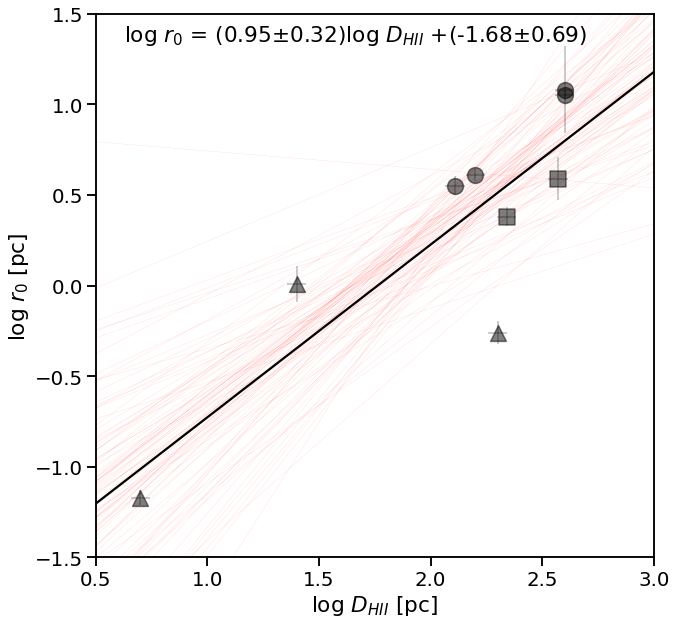

In [67]:
vmin, vmax = -0.5, 3
xgrid = np.linspace(vmin, vmax, 200)


fig, ax = plt.subplots(figsize=(10, 10))


# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")

#sigma=1.0
#for samp in lm.chain[::25]:
#    if ((dfchain["beta"].mean()-sigma*dfchain["beta"].std() )< samp["beta"] < (sigma*dfchain["beta"].std()+dfchain["beta"].mean())) & \
#       ((dfchain["alpha"].mean()-sigma*dfchain["alpha"].std() )< samp["alpha"] < (sigma*dfchain["alpha"].std()+dfchain["alpha"].mean()) ):
#        ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
#'-', c="r",alpha=0.15, lw=0.35,zorder=0)
 
for samp in lm.chain[::100]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.15, lw=0.35,zorder=0)
    
ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k",zorder=6)

marker=itertools.cycle(('o','o','o','o','s','^','s','^','^'))

#for i in [0,1,2,3,4,6,8]:
for i in range(len(samples)):
    ax.scatter(X[i], Y[i], marker=next(marker), s=250,zorder=5, c ='k', alpha=0.50)
    
ax.text(.05, .95,'log $r_0$ = (' 
        + str(np.round(dfchain["beta"].mean(),2)) + '$\pm$' + str(np.round(dfchain["beta"].std(),2))
        + ')log $D_{HII}$ +('
        + str(np.round(dfchain["alpha"].mean(),2)) + '$\pm$' + str(np.round(dfchain["alpha"].std(),2))
        + ')',  color='k', transform=ax.transAxes)
    
ax.set(
    xlim=[0.5, 3], ylim=[-1.5, 1.5],
    xlabel=r"log $D_{HII}$ [pc]", ylabel=r"log $r_0$ [pc]",
)

plt.savefig('Imgs//corr-rvsS_new_s0.pdf', bbox_inches='tight')


* Correlation of r0 with D
- If we *assume* that the relation is linear, then we can get a better estimate of the average ratio and its spread, which should be tighter than the mcmc results
- From the following table I get an unweighted average of 0.12 +/- 0.01

from: https://github.com/will-henney/PhD.Paper/commit/fc22ed750aa6c8a7cc27d26dfda49bab8af34e72

In [68]:
r0_D = s1f.r0/physical_data['L [pc]']
r0_D,r0_D.mean(),r0_D.std()

(0    0.030219
 1    0.027883
 2    0.025621
 3    0.027400
 4    0.010427
 5    0.002752
 6    0.010790
 7    0.041386
 8    0.013592
 dtype: float64,
 0.02111876504797342,
 0.012318915218365966)

In [69]:
np.hypot(physical_data['Ler [pc]']/physical_data['L [pc]'],s1f['r0+']/s1f.r0)

0    0.562526
1    0.120044
2    0.126036
3    0.157217
4    0.293660
5    0.179034
6    0.159389
7    0.249871
8    0.134172
dtype: float64

In [70]:
tab3 = ['log $r_0$','log $D$',np.round(dfchain["beta"].mean(),2),np.round(dfchain["beta"].std(),2),
       np.round(dfchain["alpha"].mean(),2),np.round(dfchain["alpha"].std(),2),
      np.round(pearsonr(X, Y)[0],2),np.round(pearsonr(X, Y)[1],3)]
tab3

['log $r_0$', 'log $D$', 0.95, 0.32, -1.68, 0.69, 0.86, 0.003]

- L vs sig

In [71]:
X, Xe, Y, Ye = [logdata[_] for _ in ['log L(H) [erg s^-1]', 'LHaer','log sig [km/s]', 'siger']]

In [72]:
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

In [73]:
lm.run_mcmc(silent=True)

In [74]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)
#dfchain

In [75]:
pearsonr(X, Y)

(0.8073618157040405, 0.008508789456101524)

In [76]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

,X,Xe,Y,Ye
count,9.000000,9.000000e+00,9.000000,9.000000
mean,38.533333,4.340000e-02,0.722222,0.064031
std,0.808177,4.906539e-18,0.260470,0.036424
min,37.180000,4.340000e-02,0.430000,0.025225
25%,38.210000,4.340000e-02,0.550000,0.034960
50%,38.780000,4.340000e-02,0.630000,0.057261
75%,39.010000,4.340000e-02,0.860000,0.077483
max,39.470000,4.340000e-02,1.240000,0.126254


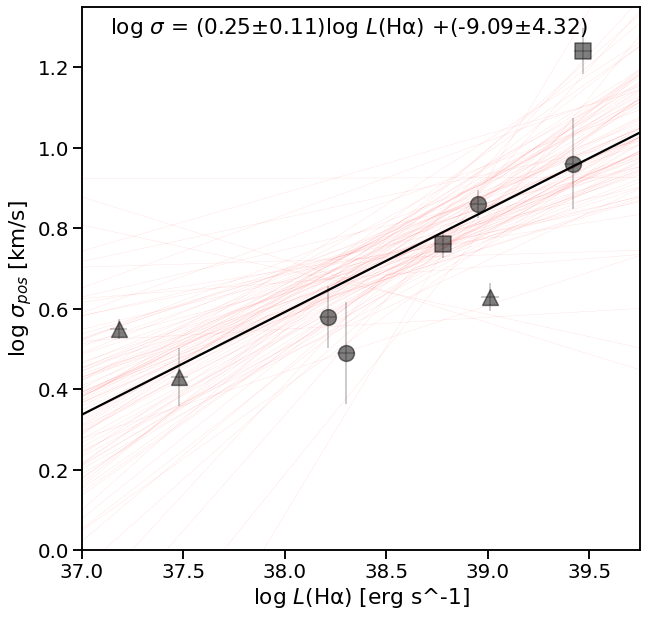

In [77]:

vmin, vmax = 36, 40
xgrid = np.linspace(vmin, vmax, 200)

fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k",zorder=10)

marker=itertools.cycle(('o','o','o','o','s','^','s','^','^'))
#for i in [0,1,2,3,4,6,8]:
for i in range(len(samples)):
    ax.scatter(X[i], Y[i], marker=next(marker), s=250,zorder=5, c ='k', alpha=0.5)
    

# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")

#for samp in lm.chain[::25]:
#    if ((dfchain["beta"].mean()-1.0*dfchain["beta"].std() )< samp["beta"] < (1.0*dfchain["beta"].std()+dfchain["beta"].mean())) & \
#       ((dfchain["alpha"].mean()-1.0*dfchain["alpha"].std() )< samp["alpha"] < (1.0*dfchain["alpha"].std()+dfchain["alpha"].mean()) ):
#        ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
#            '-', c="r",alpha=0.15, lw=0.35,zorder=0)
 
for samp in lm.chain[::100]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.15, lw=0.35,zorder=0)    
    
ax.text(.05, .95,r'log $\sigma$ = (' 
        + str(np.round(dfchain["beta"].mean(),2)) + '$\pm$' + str(np.round(dfchain["beta"].std(),2))
        + r')log $L(\mathrm{H \alpha})$ +('
        + str(np.round(dfchain["alpha"].mean(),2)) + '$\pm$' + str(np.round(dfchain["alpha"].std(),2))
        + ')',  color='k', transform=ax.transAxes)
    
ax.set(
    xlim=[37, 39.75], ylim=[0, 1.35],
    xlabel=r"log $L(\mathrm{H\alpha})$ [erg s^-1]", ylabel=r"log $\sigma_{pos}$ [km/s]",
)

plt.savefig('Imgs/corr-svsL_new_s0.pdf', bbox_inches='tight')

In [78]:
tab4 = ['log $\sigma$','log L(H)',np.round(dfchain["beta"].mean(),2),np.round(dfchain["beta"].std(),2),
       np.round(dfchain["alpha"].mean(),2),np.round(dfchain["alpha"].std(),2),
      np.round(pearsonr(X, Y)[0],2),np.round(pearsonr(X, Y)[1],3)]
tab4

['log $\\sigma$', 'log L(H)', 0.25, 0.11, -9.09, 4.32, 0.81, 0.009]

In [79]:
Y, Ye, X, Xe = [logdata[_] for _ in ['log L(H) [erg s^-1]', 'LHaer','log sig [km/s]', 'siger']]

In [80]:
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

In [81]:
lm.run_mcmc()


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.01071467 1.01997766 1.00636819 1.00537515 1.00006315 1.01827517]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00052042 1.00161369 0.99653041 0.99995284 0.9995436  1.00113267]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99991993 1.00019057 0.99854498 1.00063932 0.99943977 0.99682545]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99975088 1.00096101 0.99983203 0.99817581 0.99951491 0.9983927 ]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.0010632  1.00254505 0.99858365 1.00154336 0.99973377 0.99935182]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99962373 1.00039321 0


Iteration:  4800
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00000664 0.99997974 0.999798   1.00012508 0.99999958 0.99983521]

Iteration:  4900
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00000224 0.99996439 0.99981351 1.00029119 0.99999959 0.99986508]

Iteration:  5000
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99998589 0.99995025 0.99981158 1.00027602 0.9999996  0.99990039]


In [82]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)
#dfchain

In [83]:
pearsonr(X, Y)

(0.8073618157040405, 0.008508789456101524)

In [84]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

,X,Xe,Y,Ye
count,9.000000,9.000000,9.000000,9.000000e+00
mean,0.722222,0.064031,38.533333,4.340000e-02
std,0.260470,0.036424,0.808177,4.906539e-18
min,0.430000,0.025225,37.180000,4.340000e-02
25%,0.550000,0.034960,38.210000,4.340000e-02
50%,0.630000,0.057261,38.780000,4.340000e-02
75%,0.860000,0.077483,39.010000,4.340000e-02
max,1.240000,0.126254,39.470000,4.340000e-02


[(37.0, 40.5),
 Text(0, 0.5, 'log L(H) [erg s^-1]'),
 (0.2, 1.35),
 Text(0.5, 0, 'log $\\sigma$ [km/s]')]

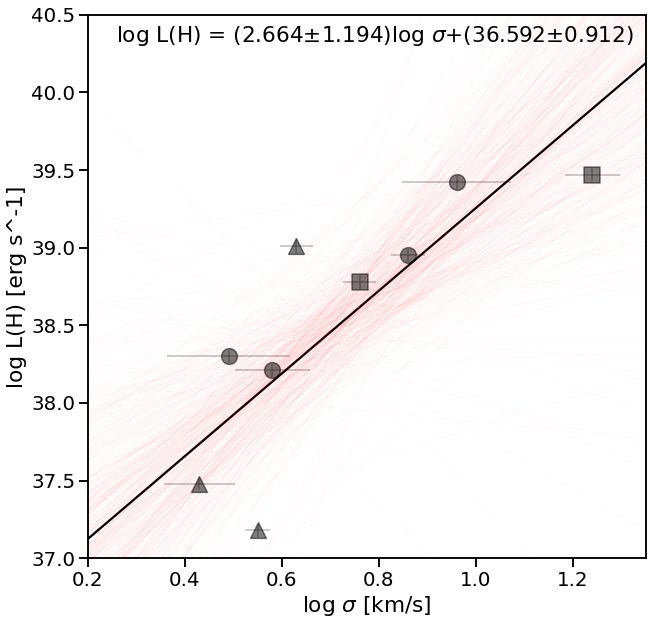

In [85]:
vmin, vmax = 0.2, 1.4
xgrid = np.linspace(vmin, vmax, 200)


fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k")

marker=itertools.cycle(('o','o','o','o','s','^','s','^','^'))
#for i in [0,1,2,3,4,6,8]:
for i in range(len(samples)):
    ax.scatter(X[i], Y[i], marker=next(marker), s=250,zorder=5, c ='k', alpha=0.5)

# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")
for samp in lm.chain[::25]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.2, lw=0.1)
    
ax.text(.05, .95,'log L(H) = (' 
        + str(np.round(dfchain["beta"].mean(),3)) + '$\pm$' + str(np.round(dfchain["beta"].std(),3))
        + ')log $\sigma$+('
        + str(np.round(dfchain["alpha"].mean(),3)) + '$\pm$' + str(np.round(dfchain["alpha"].std(),3))
        + ')',  color='k', transform=ax.transAxes)
    
ax.set(
    ylim=[37, 40.5], xlim=[0.2, 1.35],
    ylabel=r"log L(H) [erg s^-1]", xlabel=r"log $\sigma$ [km/s]",
)

In [86]:
tab5 = ['log L(H)','log $\sigma$',np.round(dfchain["beta"].mean(),2),np.round(dfchain["beta"].std(),2),
       np.round(dfchain["alpha"].mean(),2),np.round(dfchain["alpha"].std(),2),
      np.round(pearsonr(X, Y)[0],2),np.round(pearsonr(X, Y)[1],2)]
tab5

['log L(H)', 'log $\\sigma$', 2.66, 1.19, 36.59, 0.91, 0.81, 0.01]

- Distance (D) vs m

In [87]:
X, Xe, Y, Ye = [logdata[_] for _ in ['log Dist [kpc]', 'Dister [kpc]','m', 'mer']]

In [88]:
Y=np.log10(Y)

In [89]:
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

In [90]:
lm.run_mcmc(silent=True)

In [91]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)
#dfchain

In [92]:
pearsonr(X, Y)

(-0.4094721495481993, 0.2737673681710732)

In [93]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

,X,Xe,Y,Ye
count,9.000000,9.000000,9.000000,9.000000
mean,1.644444,0.019498,0.005125,0.048925
std,1.308435,0.012719,0.085778,0.036513
min,-0.400000,0.001649,-0.110653,0.012591
25%,0.370000,0.009234,-0.069578,0.023653
50%,1.790000,0.015500,0.006927,0.037637
75%,2.700000,0.034720,0.063854,0.059865
max,2.920000,0.034720,0.133735,0.113439


[(-0.2, 0.2),
 Text(0, 0.5, 'log $m$'),
 (-1.0, 3.0),
 Text(0.5, 0, 'log Dist [kpc]')]

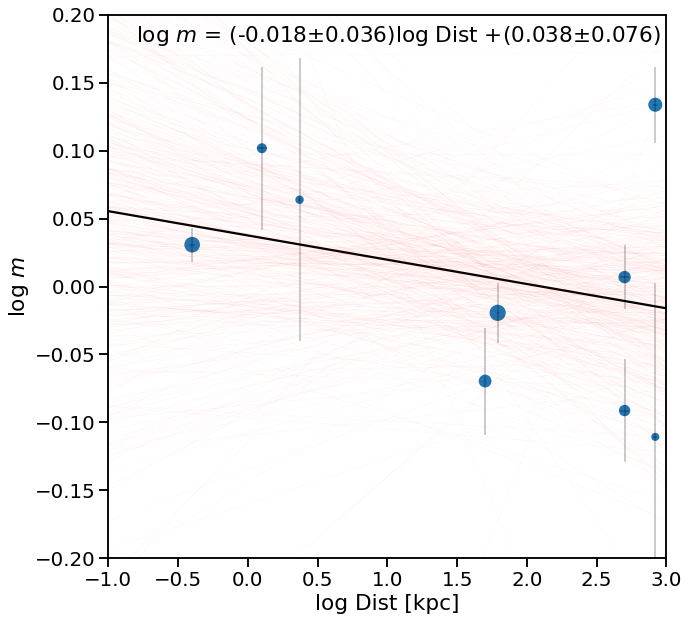

In [94]:
vmin, vmax = -1.0, 3.2
xgrid = np.linspace(vmin, vmax, 200)


fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k")
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))
# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")
for samp in lm.chain[::25]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.2, lw=0.1)
    
ax.text(.05, .95,'log $m$ = (' 
        + str(np.round(dfchain["beta"].mean(),3)) + '$\pm$' + str(np.round(dfchain["beta"].std(),3))
        + ')log Dist +('
        + str(np.round(dfchain["alpha"].mean(),3)) + '$\pm$' + str(np.round(dfchain["alpha"].std(),3))
        + ')',  color='k', transform=ax.transAxes)
    
ax.set(
  xlim=[-1.0, 3.0], ylim=[-0.2, 0.2],
    xlabel=r"log Dist [kpc]", ylabel=r"log $m$",
)

In [95]:
tab6 = ['log $m$','log Dist',np.round(dfchain["beta"].mean(),2),np.round(dfchain["beta"].std(),2),
       np.round(dfchain["alpha"].mean(),2),np.round(dfchain["alpha"].std(),2),
      np.round(pearsonr(X, Y)[0],2),np.round(pearsonr(X, Y)[1],2)]
tab6

['log $m$', 'log Dist', -0.02, 0.04, 0.04, 0.08, -0.41, 0.27]

- siglos vs sig

In [96]:
Y, Ye, X, Xe = [data[_] for _ in ['siglos [km/s]', 'sigloser [km/s]','sig [km/s]', 'siger']]

In [97]:
#Y = data['siglos [km/s]']
#Ye=data['sigloser [km/s]']
#X = data['sig [km/s]']
#Xe = data['siger']

<ErrorbarContainer object of 3 artists>

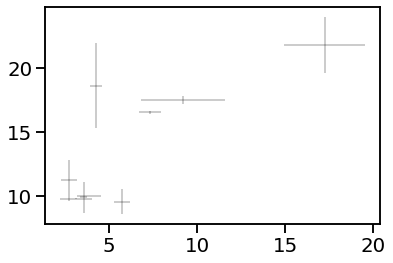

In [98]:
plt.errorbar(X, Y, xerr=Xe, yerr=Ye, ls="", elinewidth=0.4, alpha=1.0, c="k")

In [99]:
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

In [100]:
lm.run_mcmc(silent=True)

In [101]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)

In [102]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

,X,Xe,Y,Ye
count,9.000000,9.000000,9.000000,9.000000
mean,6.328315,0.922882,13.880000,1.082222
std,4.607108,0.822391,4.713104,1.134050
min,2.717109,0.206548,9.580000,0.020000
25%,3.553643,0.444701,9.900000,0.090000
50%,4.257542,0.605805,11.250000,1.000000
75%,7.323708,0.908308,17.510000,1.600000
max,17.229178,2.383642,21.770000,3.300000


In [103]:
dfchain["beta"].mean()

1.032179348655279

In [104]:
2*dfchain["beta"].std()+dfchain["beta"].mean()

1.8984297530141856

In [105]:
dfchain["beta"].mean()-2*dfchain["beta"].std()

0.1659289442963725

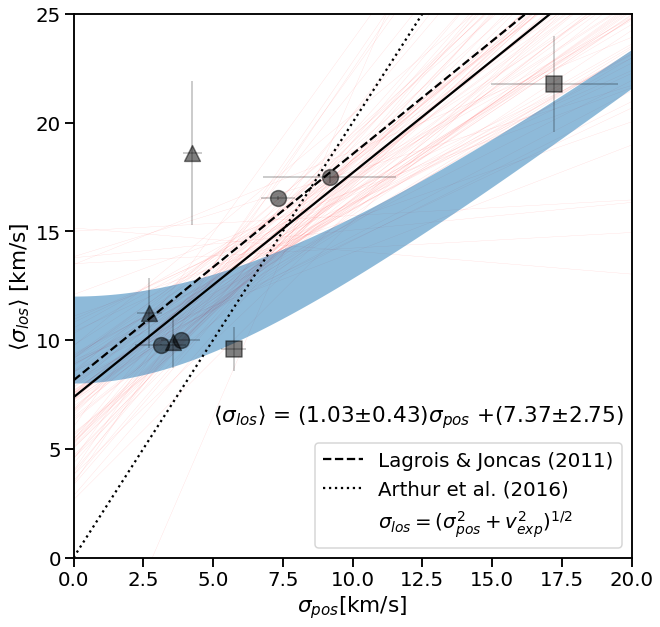

In [106]:
vmin, vmax = 0, 25
xgrid = np.linspace(vmin, vmax, 200)

marker=itertools.cycle(('o','o','o','o','s','^','s','^','^'))

fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k")

#ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))
for i in range(len(samples)):
    ax.scatter(X[i], Y[i], marker=next(marker), s=250,zorder=5, c ='k', alpha=0.5)
    
# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")

#for samp in lm.chain[::25]:
#    if ((dfchain["beta"].mean()-1.0*dfchain["beta"].std() )< samp["beta"] < (1.0*dfchain["beta"].std()+dfchain["beta"].mean())) & \
#       ((dfchain["alpha"].mean()-1.0*dfchain["alpha"].std() )< samp["alpha"] < (1.0*dfchain["alpha"].std()+dfchain["alpha"].mean()) ):
#        ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
#            '-', c="r",alpha=0.15, lw=0.35,zorder=0)
 
for samp in lm.chain[::100]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.15, lw=0.35,zorder=0)    
#ax.plot(xgrid,xgrid*1+0,linestyle='solid',color='gray',zorder=0)
#ax.plot(xgrid,xgrid*2+0,linestyle='solid',color='gray',zorder=0)
ax.plot(xgrid,xgrid*1.04+8.15,linestyle='--',color='k', label= 'Lagrois & Joncas (2011)',zorder=1)
ax.plot(xgrid,xgrid*2,linestyle=':',color='k',zorder=1, label= 'Arthur et al. (2016)')
#vexp
#ax.plot(xgrid,(xgrid**2 + 8**2)**0.5,linestyle='-.',color='k',zorder=1, label= r'$σ_{los} = (σ_{pos}^2+v_{exp}^2)^{1/2}$')

    
ax.text(.25, .25,r"$ \langle \sigma_{los} \rangle $ = ("  
        + str(np.round(dfchain["beta"].mean(),2)) + '$\pm$' + str(np.round(dfchain["beta"].std(),2))
        + ')$\sigma_{pos}$ +('
        + str(np.round(dfchain["alpha"].mean(),2)) + '$\pm$' + str(np.round(dfchain["alpha"].std(),2))
        + ')',  color='k', transform=ax.transAxes)
    
ax.set(
    xlim=[0, 20], ylim=[0, 25],
    xlabel=r"$\sigma_{pos}$[km/s]", ylabel=r"$ \langle \sigma_{los} \rangle $ [km/s]",
)


yy1 = (xgrid**2 + 8**2)**0.5
yy2 = (xgrid**2 + 12**2)**0.5
#plt.axhspan(yy2, yy1, color='green', alpha=0.75, lw=0)
ax.fill_between(xgrid, yy1, yy2, alpha = 0.5)
ax.plot(xgrid,(xgrid**2 + 8**2)**0.5,linestyle='',alpha= 0.0,color='blue',zorder=1, label= r'$σ_{los} = (σ_{pos}^2+v_{exp}^2)^{1/2}$')

plt.legend(loc='lower right')    

plt.savefig('Imgs/corr-los-vs-pos_new_s0.pdf', bbox_inches='tight')

In [107]:
tab7 = ['$\sigma_{pos}$','$\sigma_{los}$',np.round(dfchain["beta"].mean(),2),np.round(dfchain["beta"].std(),2),
       np.round(dfchain["alpha"].mean(),2),np.round(dfchain["alpha"].std(),2),
      np.round(pearsonr(X, Y)[0],2),np.round(pearsonr(X, Y)[1],2)]
tab7

['$\\sigma_{pos}$', '$\\sigma_{los}$', 1.03, 0.43, 7.37, 2.75, 0.78, 0.01]

In [108]:
x,y,z=X,Y,Ye
XX = sm.add_constant(X)
model = sm.WLS(y, XX,weights=1./(z**2))
results = model.fit()
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:          siglos [km/s]   R-squared:                       0.875
Model:                            WLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     48.81
Date:                Thu, 13 Apr 2023   Prob (F-statistic):           0.000214
Time:                        16:55:18   Log-Likelihood:                -24.174
No. Observations:                   9   AIC:                             52.35
Df Residuals:                       7   BIC:                             52.74
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6964      0.802      5.857      0.0

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [109]:
results.params

const         4.696446
sig [km/s]    1.458798
dtype: float64

In [110]:
results.bse

const         0.801858
sig [km/s]    0.208800
dtype: float64

- sig vs S

In [111]:
X, Xe, Y, Ye = [logdata[_] for _ in ['log L [pc]', 'Ler [pc]','log sig [km/s]', 'siger']]

In [112]:
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

In [113]:
lm.run_mcmc()


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00587001 1.00800741 1.00173839 1.04871989 1.00014532 1.04787536]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99898479 1.00075706 1.00716339 1.02073008 1.00007374 1.02840109]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99686165 0.99749317 0.99825624 1.00282107 1.00005092 1.00838071]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99821179 0.99909871 0.99753933 1.00728678 1.00003797 1.00726498]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99998328 1.00112532 0.99802822 1.00496085 1.00003031 1.0088688 ]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99902048 0.99945205 0


Iteration:  4800
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99983544 0.99989995 1.00000317 1.00010808 1.00001103 0.99995938]

Iteration:  4900
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99985983 0.99993598 1.00009242 1.00001768 1.00001079 1.00004432]

Iteration:  5000
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99986507 0.99990457 1.00000693 1.00000341 1.00001056 0.99997555]


In [114]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)
#dfchain

In [115]:
pearsonr(X, Y)

(0.6379225121605623, 0.06452223331148099)

In [116]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

,X,Xe,Y,Ye
count,9.000000,9.0000,9.000000,9.000000
mean,2.091111,0.0434,0.722222,0.064031
std,0.640106,0.0000,0.260470,0.036424
min,0.700000,0.0434,0.430000,0.025225
25%,2.110000,0.0434,0.550000,0.034960
50%,2.300000,0.0434,0.630000,0.057261
75%,2.570000,0.0434,0.860000,0.077483
max,2.600000,0.0434,1.240000,0.126254


[(0.2, 1.4),
 Text(0, 0.5, '$\\sigma$ [km/s]'),
 (0.5, 3.0),
 Text(0.5, 0, '$S$[km/s]')]

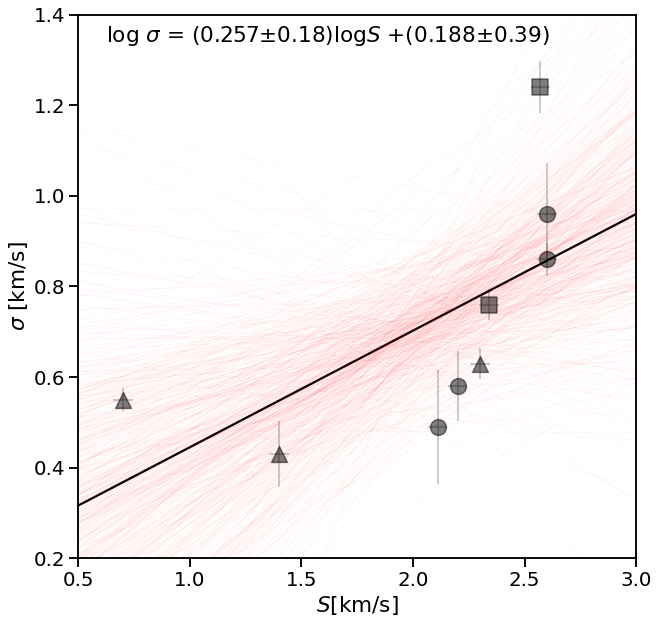

In [117]:
vmin, vmax = -0.5, 3
xgrid = np.linspace(vmin, vmax, 200)


fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k")

#ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))
marker=itertools.cycle(('o','o','o','o','s','^','s','^','^'))

#for i in [0,1,2,3,4,6,8]:
for i in range(len(samples)):
    ax.scatter(X[i], Y[i], marker=next(marker), s=250,zorder=5, c ='k', alpha=0.5)

# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")
for samp in lm.chain[::20]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.25, lw=0.1)
    
    
ax.text(.05, .95,'log $\sigma$ = (' 
        + str(np.round(dfchain["beta"].mean(),3)) + '$\pm$' + str(np.round(dfchain["beta"].std(),3))
        + ')log$S$ +('
        + str(np.round(dfchain["alpha"].mean(),3)) + '$\pm$' + str(np.round(dfchain["alpha"].std(),3))
        + ')',  color='k', transform=ax.transAxes)
    
ax.set(
    xlim=[0.5, 3.0], ylim=[0.2, 1.4],
    xlabel=r"$S$[km/s]", ylabel=r"$\sigma$ [km/s]",
)

#plt.savefig('Imgs//svss.pdf', bbox_inches='tight')

In [118]:
tab8 = ['log $\sigma$','log $S$',np.round(dfchain["beta"].mean(),2),np.round(dfchain["beta"].std(),2),
       np.round(dfchain["alpha"].mean(),2),np.round(dfchain["alpha"].std(),2),
      np.round(pearsonr(X, Y)[0],2),np.round(pearsonr(X, Y)[1],2)]
tab8

['log $\\sigma$', 'log $S$', 0.26, 0.18, 0.19, 0.39, 0.64, 0.06]

m = 1
constancy

In [119]:
m_err = [[0]*(1) for i in range(9)]


for i in range(9):

    if s1f.iloc[i][7] > 1:
        m_err[i]= s1f.iloc[i][9]
    else:
        m_err[i] = s1f.iloc[i][8]  

In [120]:
m_const = {
    'm' : s1f.m,
    'err' : m_err
            }

In [121]:
df = pd.DataFrame(m_const)
df['(m-1)/err'] = (df.m-1)/df.err
df.round(2)

,m,err,(m-1)/err
0,0.78,0.20,-1.11
1,1.36,0.15,2.36
2,1.02,0.24,0.07
3,0.81,0.07,-2.70
4,0.85,0.08,-1.92
5,1.16,0.18,0.88
6,0.96,0.05,-0.90
7,1.26,0.19,1.37
8,1.07,0.04,1.91


In [122]:
df.m.mean(),df.err.mean(),df['(m-1)/err'].mean(),df['(m-1)/err'].std()

(1.0295881110454264,
 0.13315130955647272,
 -0.004334520087577929,
 1.7626213373304287)

In [123]:
res_als = {
    'r0' : s1f.r0,
    'r0_err' : s1f['r0+'],
    'D' : physical_data['L [pc]'],
    'D_err' : physical_data['Ler [pc]'],
    'r0/D' : r0_D,
    'erat' : np.hypot(physical_data['Ler [pc]']/physical_data['L [pc]'],s1f['r0+']/s1f.r0),
     'm' : s1f.m,
    'err' : m_err,
    '(m-1)/err' : (s1f.m-1)/m_err,
    'rat_sig' : data['sig [km/s]']/physical_data['siglos [km/s]'] ,
    '2sigSd ': np.array([0.53, 0.70, 0.93, 0.98, 1.25, 0, 0.61, 0, 0.66])*2,
}

In [124]:
df_0 = pd.DataFrame(res_als) 
#df_0
df_0.insert(loc=0, column='Region', value=Names)
df_0.replace(0, np.nan, inplace=True)
df_0.round(4)

,Region,r0,r0_err,D,D_err,r0/D,erat,m,err,(m-1)/err,rat_sig,2sigSd
0,NGC 604,12.0876,6.6913,400,40.0,0.0302,0.5625,0.7751,0.2026,-1.1102,0.5241,1.06
1,NGC 595,11.1531,0.7407,400,40.0,0.0279,0.1200,1.3606,0.1528,2.3604,0.4433,1.40
2,Hubble X,4.0994,0.3145,160,16.0,0.0256,0.1260,1.0161,0.2363,0.0681,0.3836,1.86
3,Hubble V,3.5620,0.4321,130,13.0,0.0274,0.1572,0.8104,0.0703,-2.6972,0.3189,1.96
4,30 Dor,3.8578,1.0652,370,37.0,0.0104,0.2937,0.8520,0.0773,-1.9158,0.7914,2.50
5,Carina,0.5505,0.0817,200,20.0,0.0028,0.1790,1.1584,0.1795,0.8822,0.2289,NaN
6,NGC 346,2.3737,0.2946,220,22.0,0.0108,0.1594,0.9564,0.0484,-0.9019,0.5990,1.22
7,M8,1.0346,0.2369,25,2.5,0.0414,0.2499,1.2640,0.1928,1.3691,0.2415,NaN
8,Orion,0.0680,0.0061,5,0.5,0.0136,0.1342,1.0734,0.0385,1.9065,0.3590,1.32


In [125]:
df_0.describe()

,r0,r0_err,D,D_err,r0/D,erat,m,err,(m-1)/err,rat_sig,2sigSd
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,7.000000
mean,4.309626,1.095905,212.222222,21.222222,0.021119,0.220217,1.029588,0.133151,-0.004335,0.432192,1.617143
std,4.397921,2.123767,151.288448,15.128845,0.012319,0.141033,0.203995,0.074812,1.762621,0.181551,0.509827
min,0.067959,0.006079,5.000000,0.500000,0.002752,0.120044,0.775080,0.038487,-2.697224,0.228900,1.060000
25%,1.034650,0.236922,130.000000,13.000000,0.010790,0.134172,0.851966,0.070281,-1.110215,0.318929,1.270000
50%,3.561972,0.314483,200.000000,20.000000,0.025621,0.159389,1.016079,0.152778,0.068058,0.383559,1.400000
75%,4.099377,0.740691,370.000000,37.000000,0.027883,0.249871,1.158387,0.192800,1.369140,0.524113,1.910000
max,12.087638,6.691312,400.000000,40.000000,0.041386,0.562526,1.360615,0.236254,2.360385,0.791418,2.500000


In [126]:
means = [[0]*(1) for i in range(12)]
means[0]  = 'means'
std = [[0]*(1) for i in range(12)]
std[0]  = 'std'

for i in range(11):
    means[i+1] = df_0.iloc[:,i+1].mean()
    std[i+1] = df_0.iloc[:,i+1].std()
    
means = pd.Series(data = means, index = df_0.columns, name = 9)
std = pd.Series(data = std, index = df_0.columns, name = 10)

df_0 = df_0.append(means)
df_0 = df_0.append(std)

In [127]:
#Corr.rename(columns={0:'A',1:'B',2:'C',3:'DC',4:'E',5:'DE',6:'F',7:'G'}, inplace=True)
df_0.round(2)

,Region,r0,r0_err,D,D_err,r0/D,erat,m,err,(m-1)/err,rat_sig,2sigSd
0,NGC 604,12.09,6.69,400.00,40.00,0.03,0.56,0.78,0.20,-1.11,0.52,1.06
1,NGC 595,11.15,0.74,400.00,40.00,0.03,0.12,1.36,0.15,2.36,0.44,1.40
2,Hubble X,4.10,0.31,160.00,16.00,0.03,0.13,1.02,0.24,0.07,0.38,1.86
3,Hubble V,3.56,0.43,130.00,13.00,0.03,0.16,0.81,0.07,-2.70,0.32,1.96
4,30 Dor,3.86,1.07,370.00,37.00,0.01,0.29,0.85,0.08,-1.92,0.79,2.50
5,Carina,0.55,0.08,200.00,20.00,0.00,0.18,1.16,0.18,0.88,0.23,NaN
6,NGC 346,2.37,0.29,220.00,22.00,0.01,0.16,0.96,0.05,-0.90,0.60,1.22
7,M8,1.03,0.24,25.00,2.50,0.04,0.25,1.26,0.19,1.37,0.24,NaN
8,Orion,0.07,0.01,5.00,0.50,0.01,0.13,1.07,0.04,1.91,0.36,1.32
9,means,4.31,1.10,212.22,21.22,0.02,0.22,1.03,0.13,-0.00,0.43,1.62


In [128]:
(df_0.round(2)).to_latex('latex-files/res_als_new_s0.tex', escape=False, caption='m and r0 analysis',index=False)

L(Ha) and Q_0 stuff

In [129]:
qtol = 8.56e11

In [130]:
physical_data.LHa

0    2.630000e+39
1    8.910000e+38
2    1.620000e+38
3    1.990000e+38
4    2.930000e+39
5    1.020000e+39
6    6.000000e+38
7    3.000000e+37
8    1.510000e+37
Name: LHa, dtype: float64

In [131]:
np.round(np.log10(physical_data.LHa*qtol),2)

0    51.35
1    50.88
2    50.14
3    50.23
4    51.40
5    50.94
6    50.71
7    49.41
8    49.11
Name: LHa, dtype: float64

In [132]:
physical_data.LHa / physical_data.LHa[8]

0    174.172185
1     59.006623
2     10.728477
3     13.178808
4    194.039735
5     67.549669
6     39.735099
7      1.986755
8      1.000000
Name: LHa, dtype: float64

Results to table

In [133]:
Corr = pd.DataFrame([tab0, tab1,tab2,tab3,tab4,tab6,tab7,tab8])
Corr.rename(columns={0:'A',1:'B',2:'C',3:'DC',4:'E',5:'DE',6:'F',7:'G'}, inplace=True)
Corr=Corr.sort_values( by='G', ascending=True)
Corr

,A,B,C,DC,E,DE,F,G
3,log $r_0$,log $D$,0.95,0.32,-1.68,0.69,0.86,0.003
4,log $\sigma$,log L(H),0.25,0.11,-9.09,4.32,0.81,0.009
6,$\sigma_{pos}$,$\sigma_{los}$,1.03,0.43,7.37,2.75,0.78,0.010
7,log $\sigma$,log $S$,0.26,0.18,0.19,0.39,0.64,0.060
1,log $\sigma$,log $r_{0}$,0.18,0.19,0.67,0.14,0.50,0.174
5,log $m$,log Dist,-0.02,0.04,0.04,0.08,-0.41,0.270
2,log $m$,log $\sigma$,-0.10,0.20,0.08,0.15,-0.37,0.333
0,log $m$,log $r_{0}$,-0.02,0.07,0.01,0.05,-0.29,0.451


In [134]:
Corrx=(Corr.groupby(Corr.columns.str[-1], axis=1).apply(lambda x: x.astype(str).apply(' $\pm$ '.join, 1)))
Corr1=Corrx[['A','B','C','E','F','G']].copy()

In [135]:
Corr1.rename(columns={'A':'Y','B':'X','C':'a','E':'b','F':'r','G':'p'}, inplace=True)
Corr1

,Y,X,a,b,r,p
3,log $r_0$,log $D$,0.95 $\pm$ 0.32,-1.68 $\pm$ 0.69,0.86,0.003
4,log $\sigma$,log L(H),0.25 $\pm$ 0.11,-9.09 $\pm$ 4.32,0.81,0.009
6,$\sigma_{pos}$,$\sigma_{los}$,1.03 $\pm$ 0.43,7.37 $\pm$ 2.75,0.78,0.01
7,log $\sigma$,log $S$,0.26 $\pm$ 0.18,0.19 $\pm$ 0.39,0.64,0.06
1,log $\sigma$,log $r_{0}$,0.18 $\pm$ 0.19,0.67 $\pm$ 0.14,0.5,0.174
5,log $m$,log Dist,-0.02 $\pm$ 0.04,0.04 $\pm$ 0.08,-0.41,0.27
2,log $m$,log $\sigma$,-0.1 $\pm$ 0.2,0.08 $\pm$ 0.15,-0.37,0.333
0,log $m$,log $r_{0}$,-0.02 $\pm$ 0.07,0.01 $\pm$ 0.05,-0.29,0.451


In [136]:
Corr1.to_latex('latex-files/scaling-relations_new_s0.tex', escape=False, caption='Regressions (Y = aX + b).',index=False)

In [137]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 139.47186422348022 seconds ---


In [138]:
!jupyter nbconvert --to script --no-prompt correlations-regressions_2sigma.ipynb

[NbConvertApp] Converting notebook correlations-regressions_2sigma.ipynb to script
[NbConvertApp] Writing 35112 bytes to correlations-regressions_2sigma.py
